In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.optimize as optimize
from sklearn.metrics import mean_absolute_error
import time

# Gradient Boosting
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import seaborn
from scipy.stats import norm

#ARIMA 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# UCM
import statsmodels.api as sm
from IPython.display import display, Latex

# integration
from scipy.integrate import simps
from numpy import trapz

In [4]:
df = pd.read_csv(r'E:\California data\csvs\toy_dataset.csv')

## Only running out to 2013
- validating with 2013 to 2015 AUC
- modified production_model function by changing time_length

In [35]:
def Production_models(df, time_future, title):
    
    #This is the time that the model begins    
    time_length = len(df['month'].values) - 24
    
    ##ARPs
    ## --- need to change well 7 potentially

    arps = df[['Production', 'month']]

    arps.head()

    def Exponential(t, di):
        qi = arps['Production'].max()
        return qi*np.exp(-di*t)

    def Hyperbolic(t, b, di):
        qi = arps['Production'].max()
        return qi/((1.0+b*di*t)**(1/b))

    def Harmonic(t, qi, di):
        return qi/(1+di*t)


    arps = df[['Production', 'month']]
    arps.head()


    qi = arps['Production'].max()
    x_arps = arps['month'].values
    y_arps = arps['Production'].values


    #Optimizing Curves
    popt, pcov = curve_fit(Exponential, x_arps, y_arps)
    exp_vars = popt
    popt, pcov = curve_fit(Hyperbolic, x_arps, y_arps)
    unconstrained_vars = popt
    popt, pcov = curve_fit(Hyperbolic, x_arps, y_arps, bounds= ([0,0], [1,5]))
    constrained_vars = popt

    #analyzing error
    MAE_exp = mean_absolute_error(y_arps, Exponential(x_arps, *exp_vars))
    MAE_Hyper = mean_absolute_error(y_arps, Hyperbolic(x_arps, *unconstrained_vars))
    MAE_Hyper_constrained = mean_absolute_error(y_arps, Hyperbolic(x_arps, *constrained_vars))

    Errors = {
        "Exponential" : MAE_exp,
        "Hyperbolic_u" : MAE_Hyper,
        "Hyperbolic_c" : MAE_Hyper_constrained
    }



    ## best fit + 120 months in the future
    x_arps_future = range(0, time_length+time_future)
    production_arps = Hyperbolic(x_arps_future, *unconstrained_vars)


    ########GB
    GB_df = df[['Production', 'month']]
    y_GB = GB_df['Production'].values
    y_GB = y_GB[0: time_length]

    x_GB = GB_df['month'].values
    x_GB = x_GB[0: time_length]
    X_GB = x_GB.reshape(-1,1)
    X_GB = x_GB[:, np.newaxis]
    x_plot_GB = np.linspace(0, time_length+time_future, time_length+time_future)
    X_plot_GB = x_plot_GB[:, np.newaxis]
    lw = 2
    degree = 1

    model_GB = Pipeline(steps=[('poly', PolynomialFeatures(degree)),
                    ('ridge', Ridge(fit_intercept=True))])
    model_GB.fit(X_GB, y_GB)
    y_plot_GB = model_GB.predict(X_plot_GB)

    alpha = 0.95
    ##Haven't tuned any parameters yet
    GBR = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                    n_estimators=100, max_depth=5,
                                    learning_rate=.1, min_samples_leaf=5,
                                    min_samples_split=3)
    GBR.fit(X_GB,y_GB)
    y_upper = GBR.predict(X_plot_GB)

    GBR.set_params(alpha=1.0 - alpha)
    GBR.fit(X_GB, y_GB)
    y_lower = GBR.predict(X_plot_GB)


    GBR.set_params(loss='ls')
    GBR.fit(X_GB,y_GB)
    y_pred_GB = GBR.predict(X_plot_GB)

    ## X_plot_GB, y_pred_GB

    ## ARIMA Model
    ARIMA_df = df[['Production', 'month']]

    X_AR = ARIMA_df['Production'].values[0: time_length]
    X_AR = X_AR.reshape(-1,1)
    X_AR = X_AR.astype('float32')
    size = len(X_AR) - 1
    train_AR, test_AR = X_AR[0:size], X_AR[size:]

    ## order(p,d,q) - p = order of AR, d = order of I, and q = order of MA
    ## need to tune these--
    model_AR = ARIMA(train_AR, order = (1,1,1))
    model_fit_AR = model_AR.fit(disp=False)

    ## set confidence interval to whatever
    confidence_interval = 95
    a = (100 - confidence_interval)/100

    forecast_AR, stderr, conf = model_fit_AR.forecast(alpha = a)

    plot_end_value = len(train_AR) + time_future
    plot_start_value = len(train_AR)-size+1

    confidence_interval = 50
    a = (100 - confidence_interval)/100
    ### Could plot until it reaches an intercept of zero then integrate

    prediction_AR = model_fit_AR.forecast(steps=time_future)
    #print(ARIMA_forecats)

    ## end values
    ## ARIMA_forecats
    #print(prediction_AR[0])
    X_AR_pred = range(time_length,time_length+time_future)
    #len(prediction_AR[0])

    ## UCM - Unobserved component model

    oildata = df[['Production', 'month']]
    #index = df['month']
    #oildata = pd.Series(data_well7, index)
    # Model specifications
    # Unrestricted model, using string specification
    unrestricted_model = {
        'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    }

    # Unrestricted model, setting components directly
    # This is an equivalent, but less convenient, way to specify a
    # local linear trend model with a stochastic damped cycle:
    # unrestricted_model = {
    #     'irregular': True, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True,
    #     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    # }

    # The restricted model forces a smooth trend
    restricted_model = {
        'level': 'smooth trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    }

    # Restricted model, setting components directly
    # This is an equivalent, but less convenient, way to specify a
    # smooth trend model with a stochastic damped cycle. Notice
    # that the difference from the local linear trend model is that
    # `stochastic_level=False` here.
    # unrestricted_model = {
    #     'irregular': True, 'level': True, 'stochastic_level': False, 'trend': True, 'stochastic_trend': True,
    #     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
    # }


    # well production
    prod_mod = sm.tsa.UnobservedComponents(oildata['Production'], **unrestricted_model)
    prod_res = prod_mod.fit(method='powell', disp=False)

    prod_restricted_mod = sm.tsa.UnobservedComponents(oildata['Production'], **restricted_model)
    prod_restricted_res = prod_restricted_mod.fit(method='powell', disp=False)
    predict_ucm = prod_res.forecast(steps=time_future)
    ucm_pred = predict_ucm.values

    predict_ucm_res = prod_restricted_res.forecast(steps=time_future)
    ucm_pred_res = predict_ucm_res.values

    y_GB_future = y_pred_GB[time_length:time_length+time_future]
    production_arps_future = production_arps[time_length:time_length+time_future]
    AR_future =  prediction_AR[0]

    ensemble_df = []

    for i in range(0,time_future):
        average = (y_GB_future[i] + production_arps_future[i] + AR_future[i] + ucm_pred[i])/4
        ensemble_df.append(average)

    #Some Combined Plots:
#    fig = plt.figure(figsize = (12,12))

    ARIMA_pred = prediction_AR[0]
    plt.plot(x_arps, y_arps, marker='', color='black', linewidth=1, label = "Well Production")
    plt.plot(x_arps_future, production_arps, 'r-', label = 'ARPs')
    plt.plot(X_plot_GB, y_pred_GB, '#0068b0', label=u'Gradient Boosting')
    plt.plot(X_AR_pred, ARIMA_pred, marker = '', color = 'blue', label = 'ARIMAX', linewidth=1)
    plt.plot(X_AR_pred, ucm_pred, marker = '', color='yellowgreen', label = 'UCM - unrestricted', linewidth=1)
    plt.plot(X_AR_pred, ensemble_df, marker = '', color='skyblue', label = 'Ensemble Model', linewidth=1)
    
    plt.title(str(title))
    plt.xlabel('months')
    plt.ylabel('bbl')
    plt.legend()
    plt.show()
    plt.savefig(r'E:\California data\csvs\graphs\forecast'+str(title)+'.png',
                format = "PNG", bbox_inches = 'tight')
    
    def compute_area(y, init, final):
        for i in range(init, final):
            if y[i] < 0:
                y[i] = 0
            else:
                y[i] = y[i]
        min_y = np.argmin(y)
        y  = y[init:min_y]
        x = min_y - init
        area_t = trapz(y, dx=x)
        area_s = simps(y, dx=x)
        area = (area_t + area_s)/2
        return area_t

    def compute_area_GB(y, init, final):
        for i in range(init, final):
            if y[i] < 0:
                y[i] = 0
            else:
                y[i] = y[i]

        y  = y[init:final]
        x = final - init
        area_t = trapz(y, dx=x)
        area_s = simps(y, dx=x)
        area = (area_t + area_s)/2
        return area_t
    
    Data_length = time_length
    predict_length = Data_length + time_future

    ARPs_pred_corr = compute_area(production_arps, Data_length, predict_length)

    GB_pred_corr = compute_area_GB(y_pred_GB, Data_length, predict_length)

    ARIMA_pred_corr = compute_area(ARIMA_pred, 0, time_future)

    UCM_pred_corr = compute_area(ucm_pred, 0, time_future)

    Ensemble_pred_corr = compute_area(ensemble_df, 0, time_future)

    EUR = round((ARPs_pred_corr + GB_pred_corr + ARIMA_pred_corr + 
                         UCM_pred_corr + Ensemble_pred_corr) / 5, 1)

    actual_EUR = compute_area_GB(y_arps, Data_length, predict_length)

    return ARPs_pred_corr, GB_pred_corr, ARIMA_pred_corr, UCM_pred_corr, Ensemble_pred_corr, EUR, actual_EUR



In [36]:
import warnings
warnings.filterwarnings("ignore")

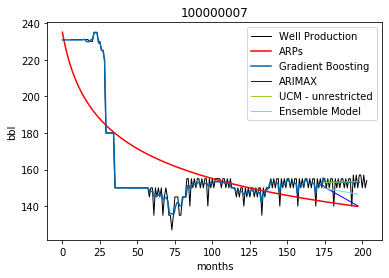

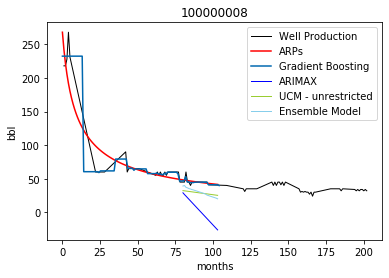

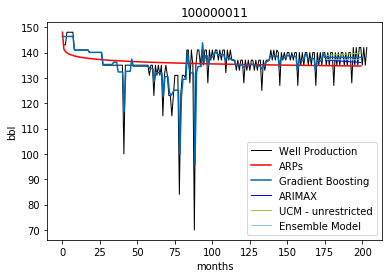

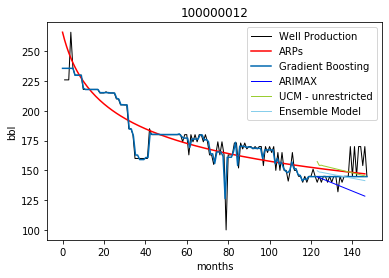

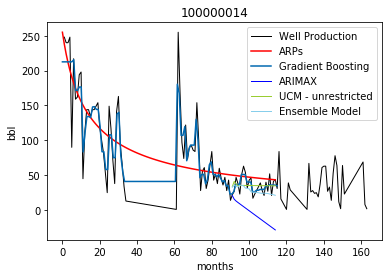

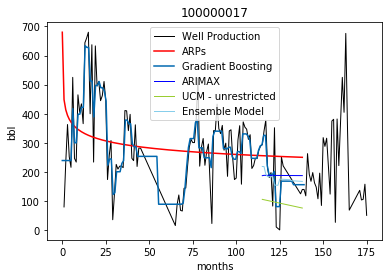

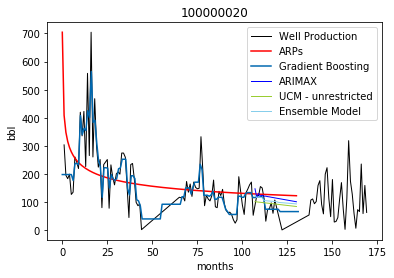

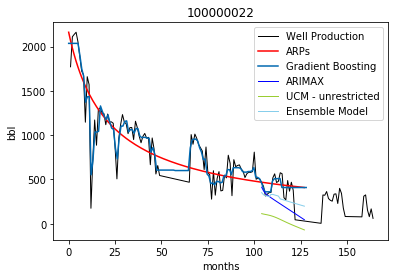

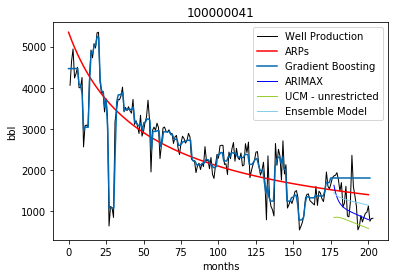

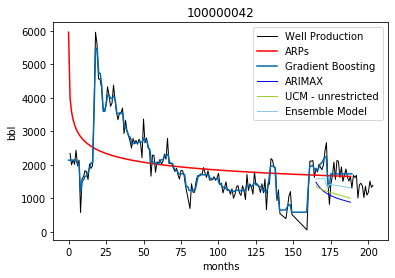

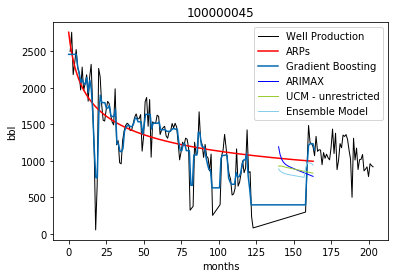

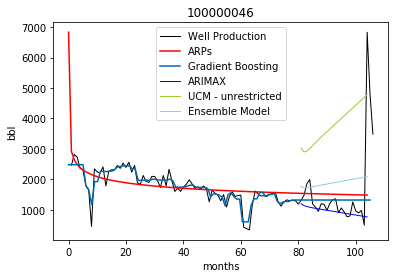

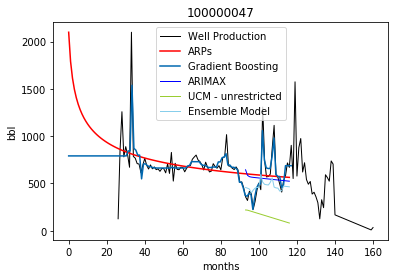

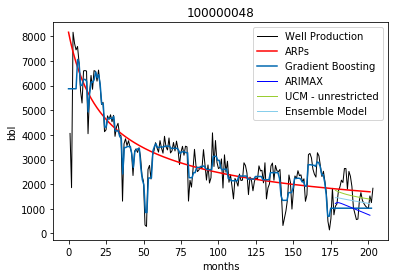

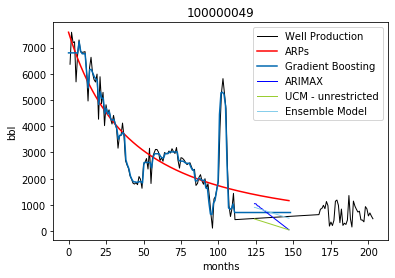

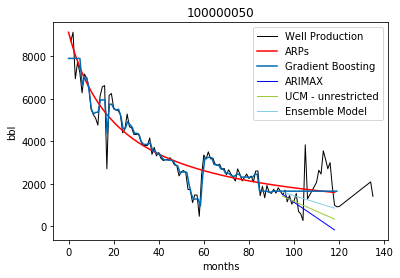

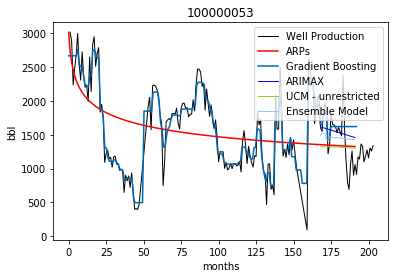

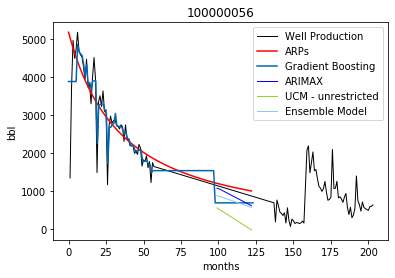

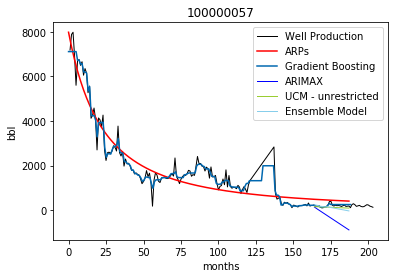

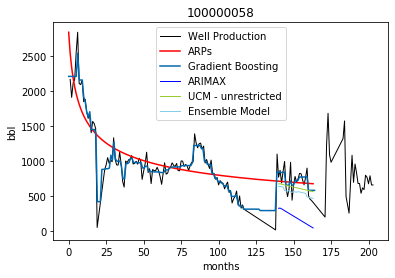

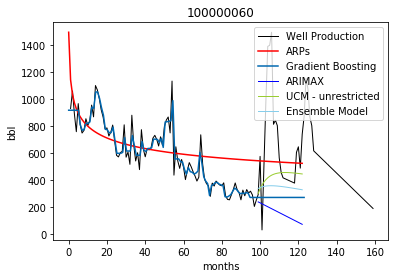

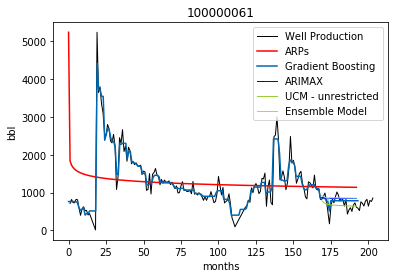

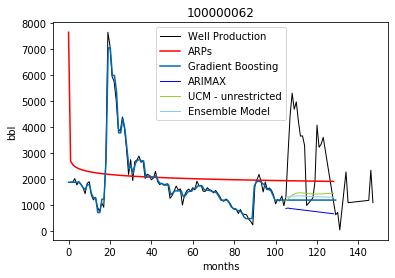

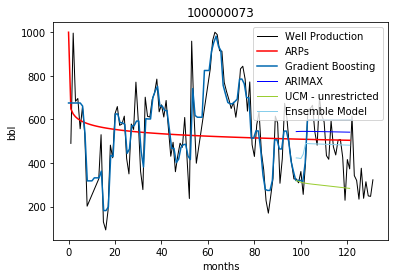

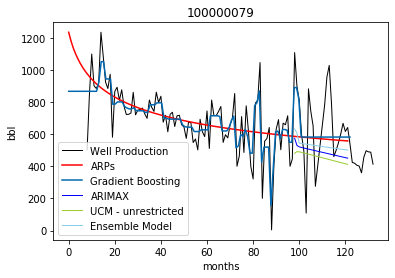

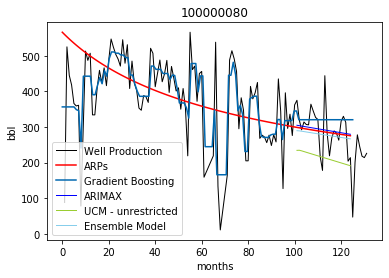

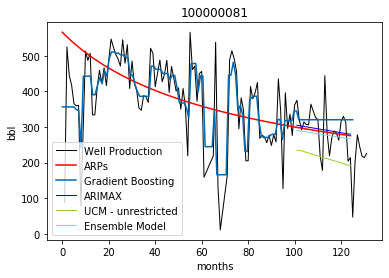

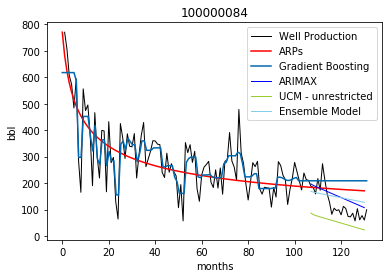

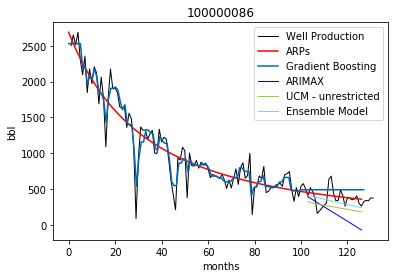

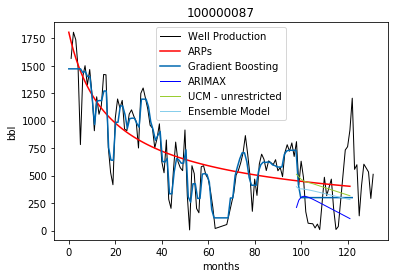

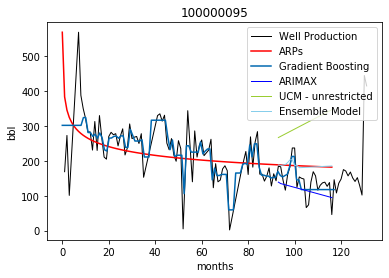

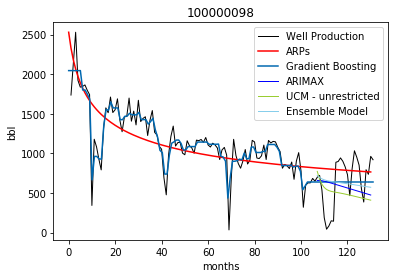

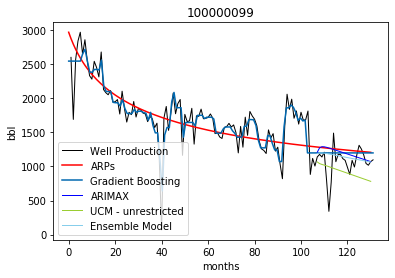

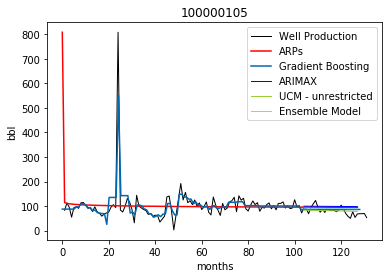

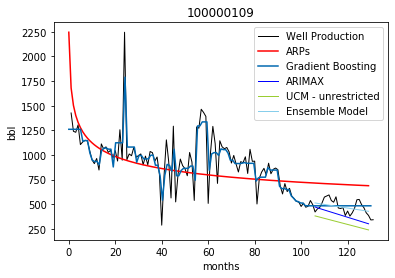

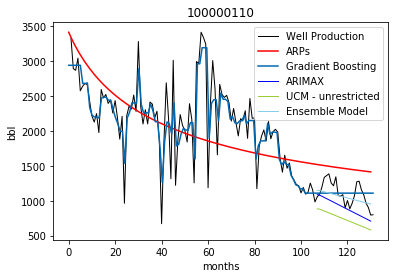

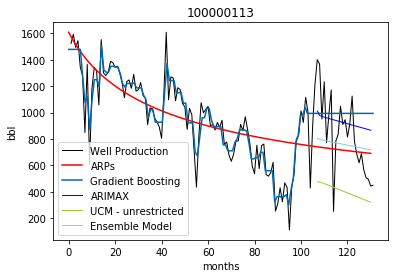

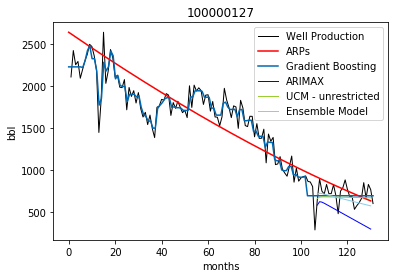

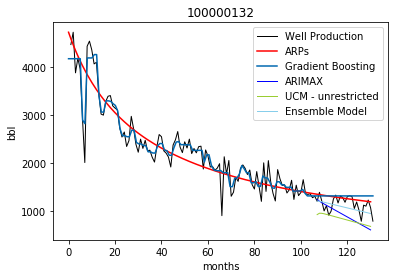

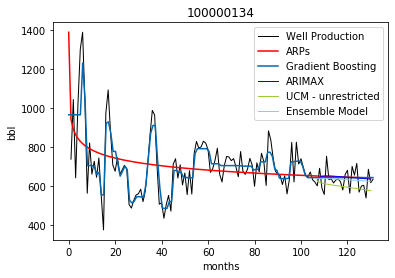

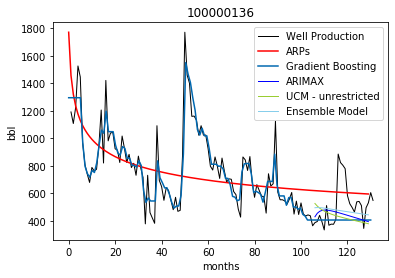

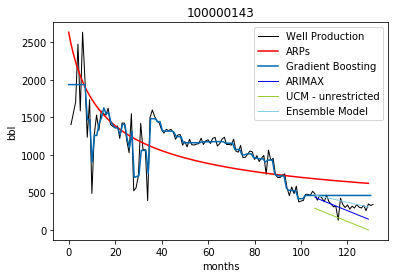

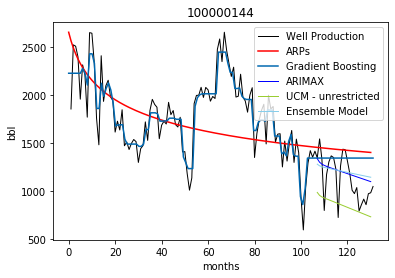

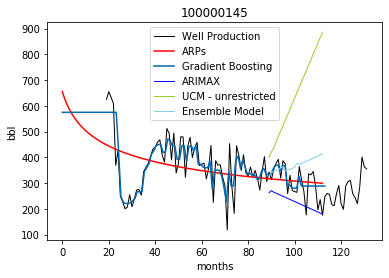

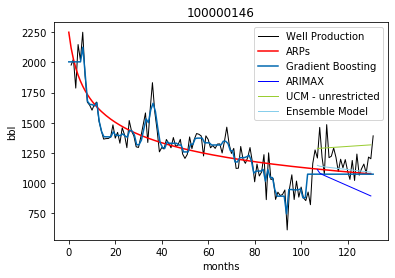

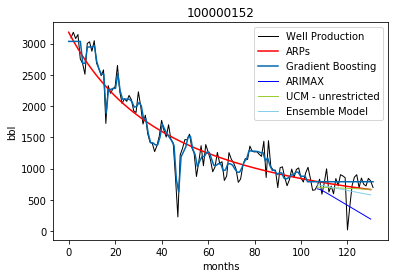

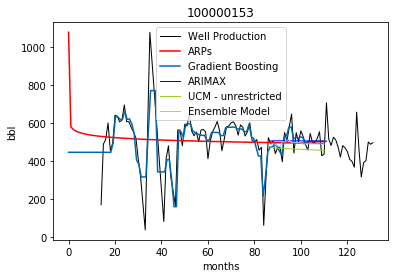

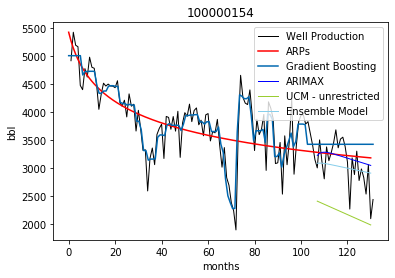

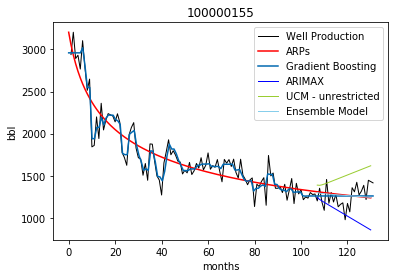

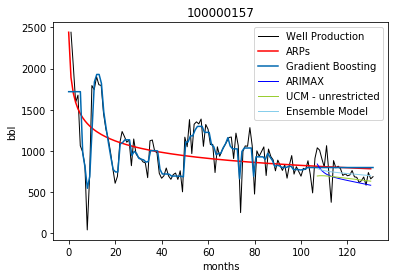

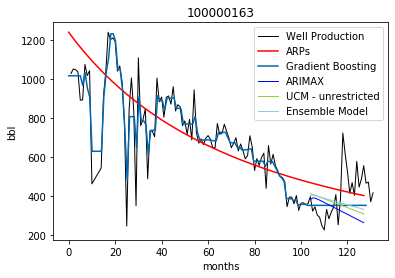

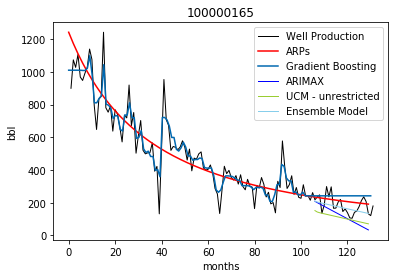

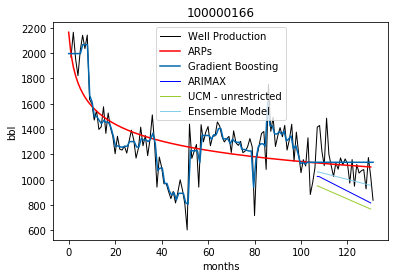

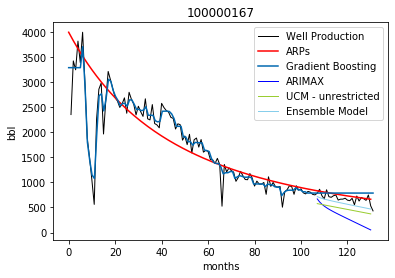

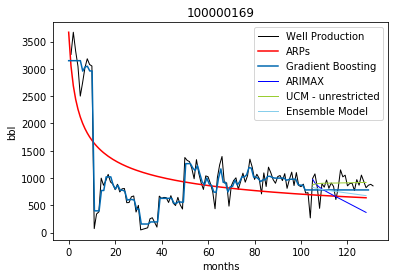

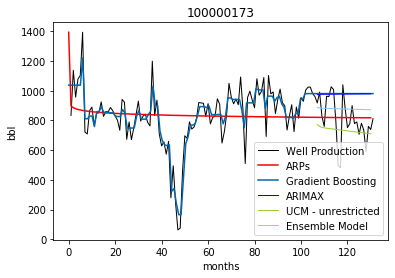

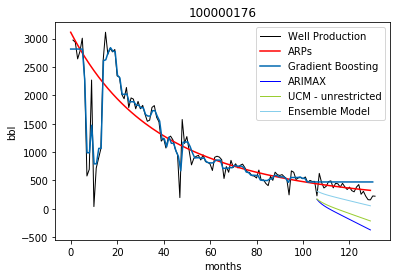

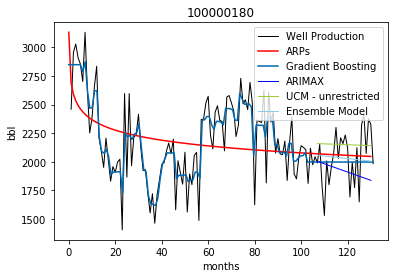

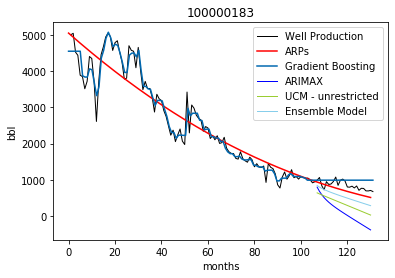

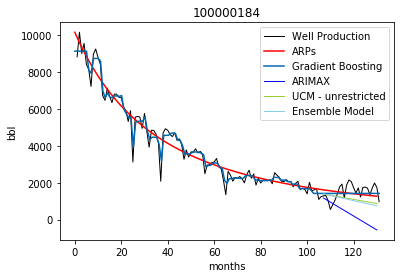

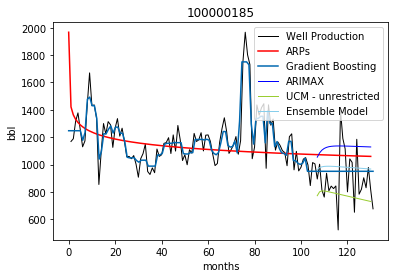

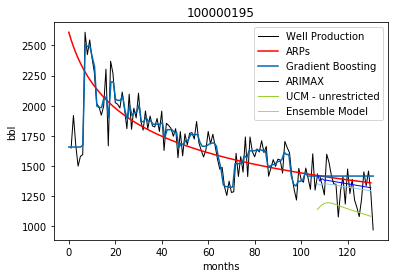

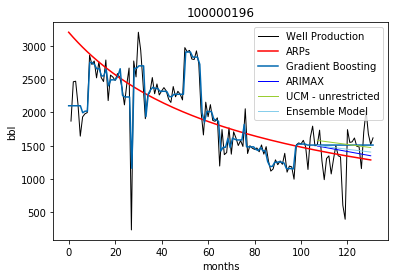

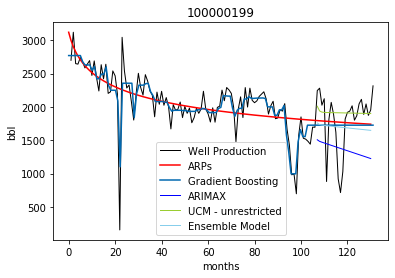

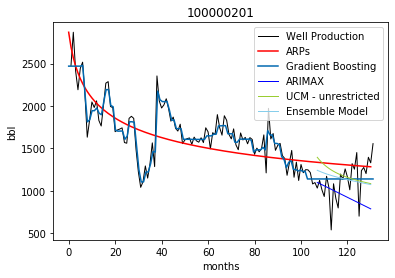

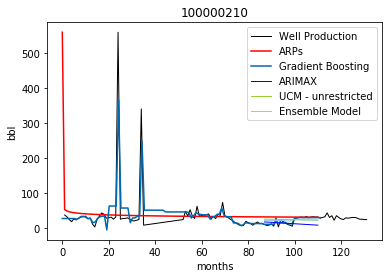

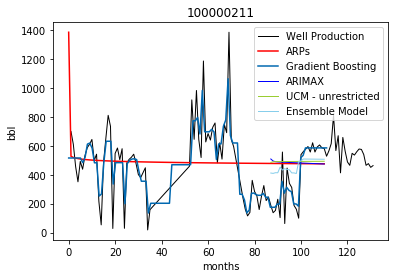

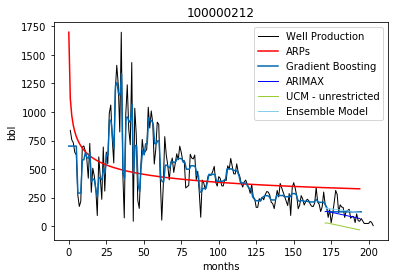

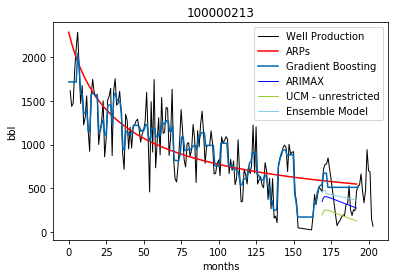

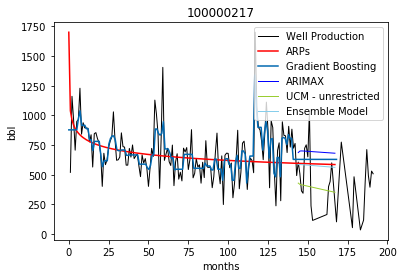

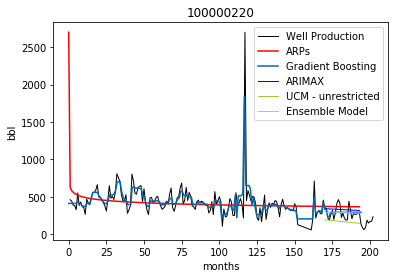

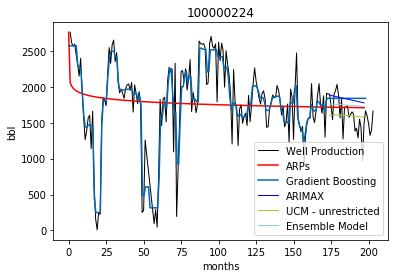

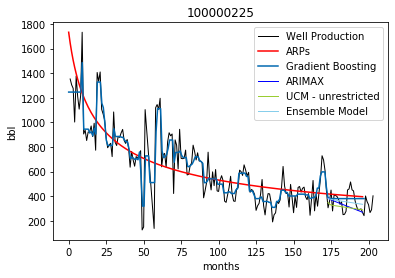

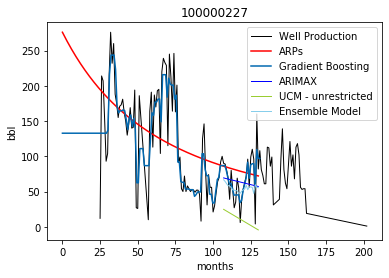

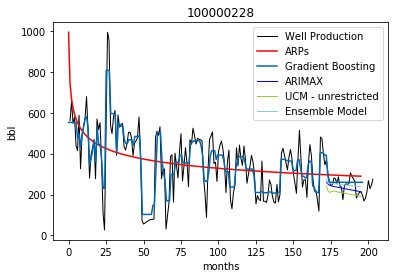

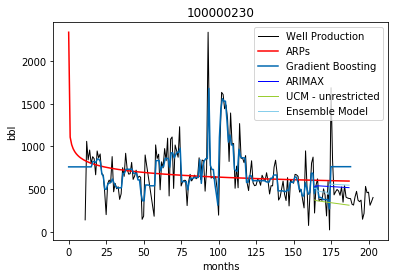

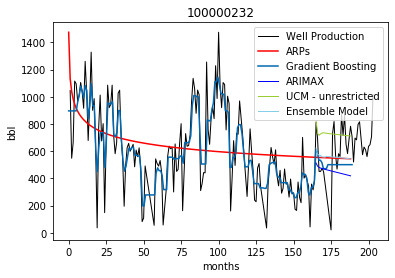

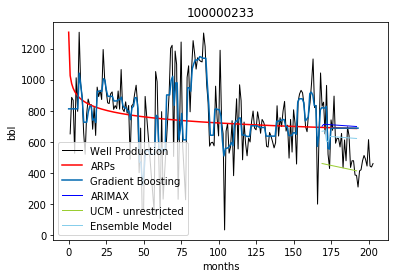

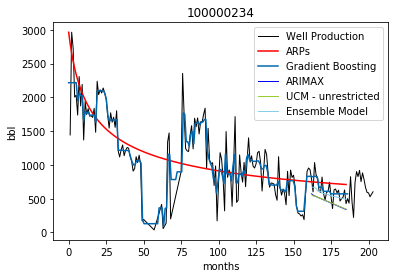

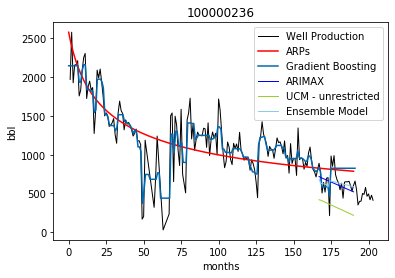

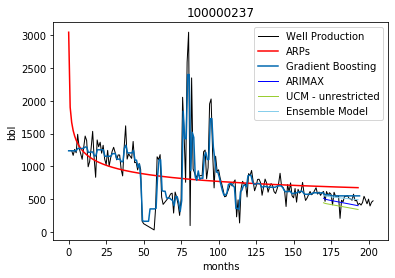

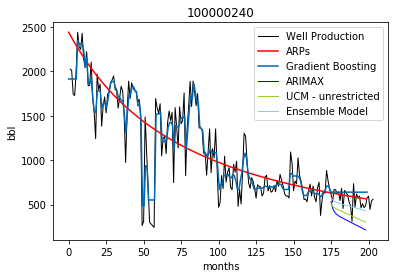

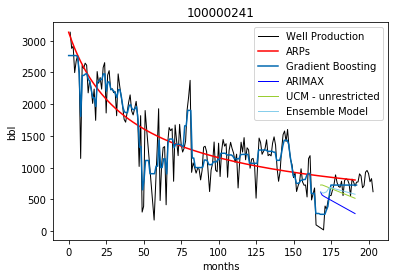

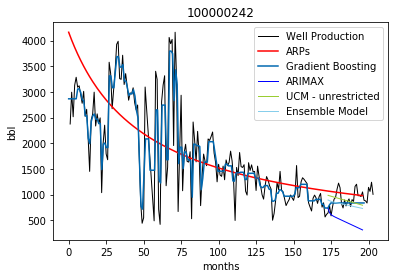

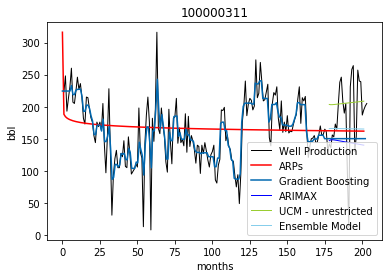

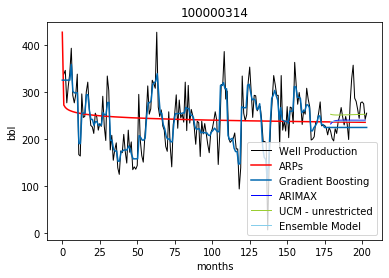

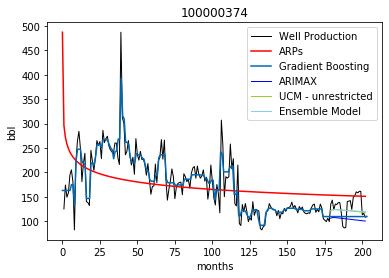

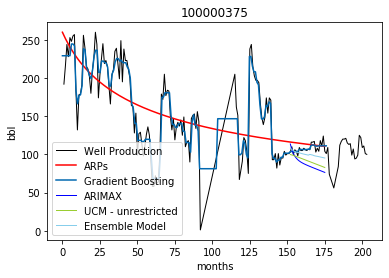

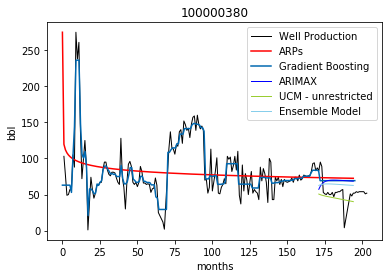

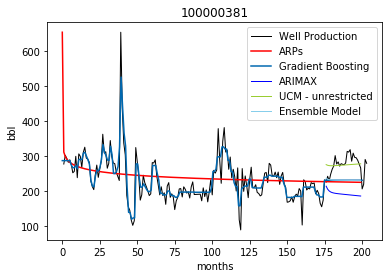

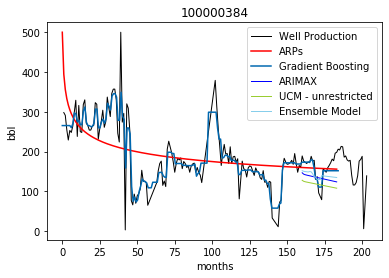

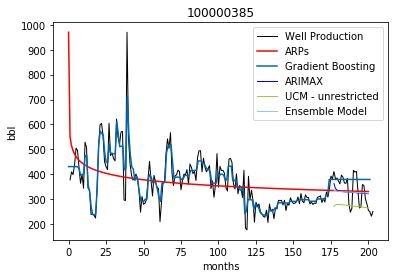

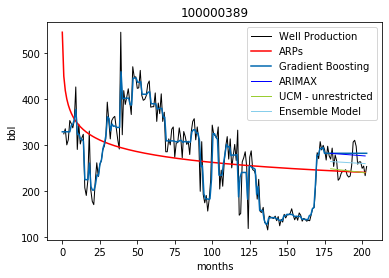

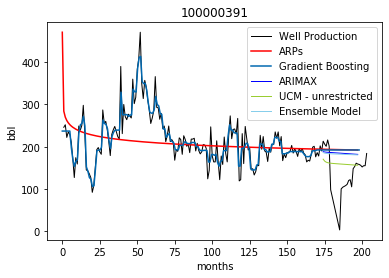

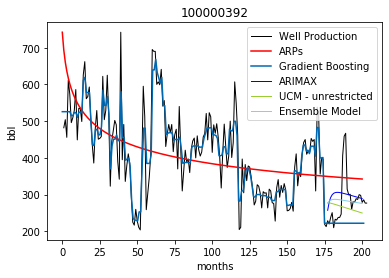

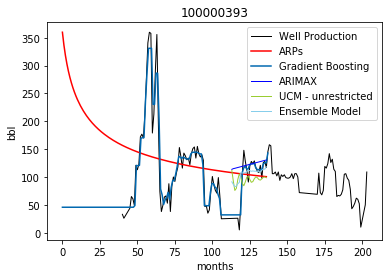

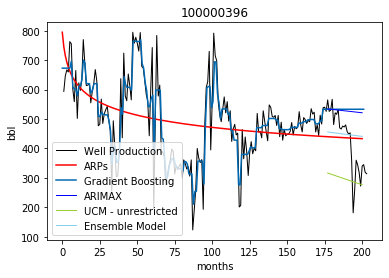

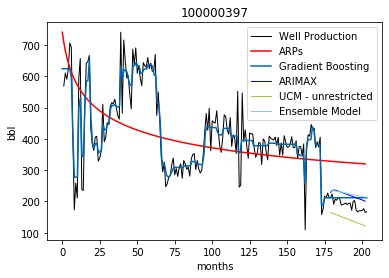

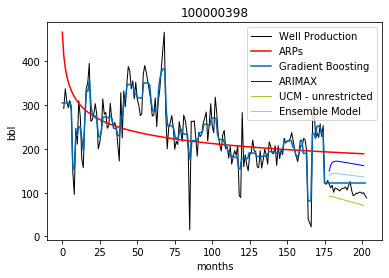

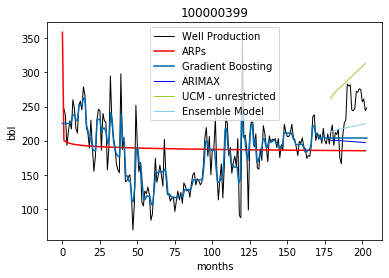

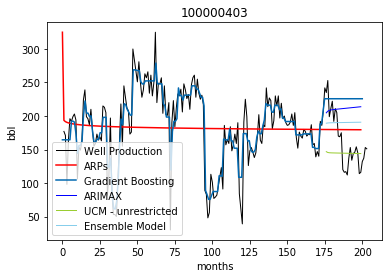

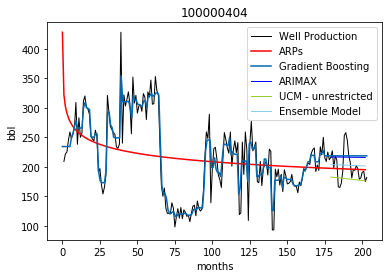

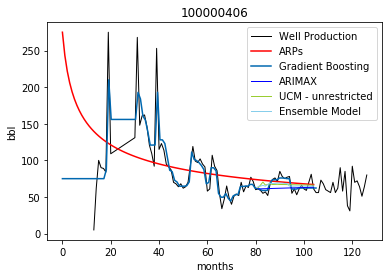

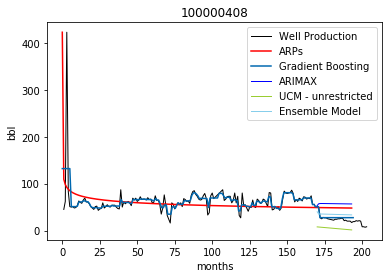

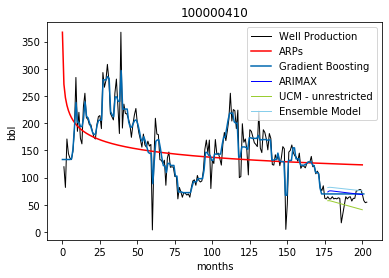

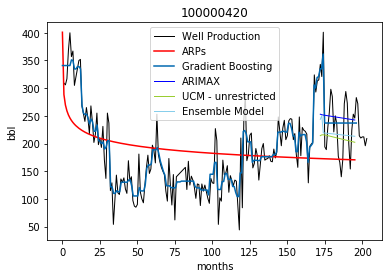

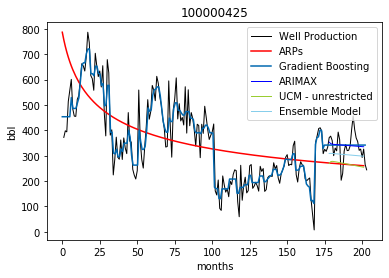

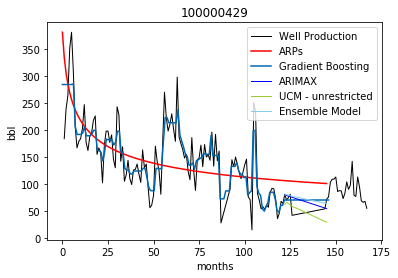

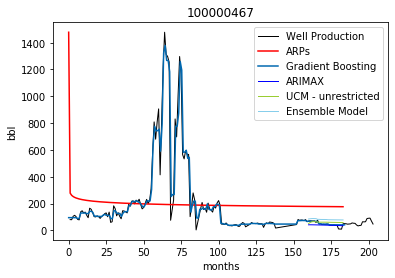

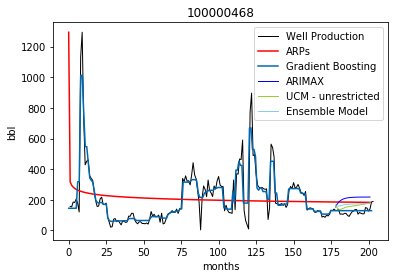

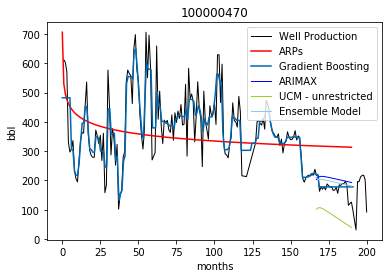

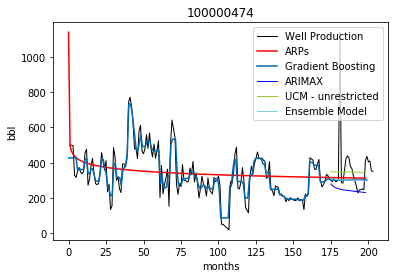

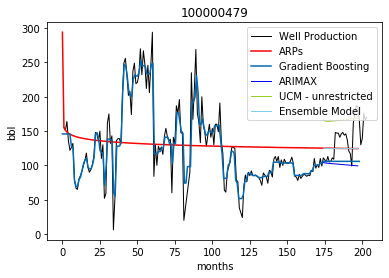

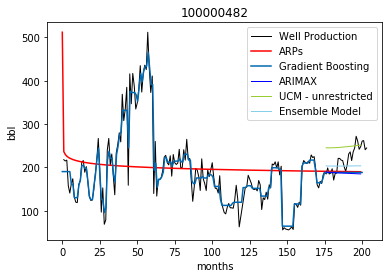

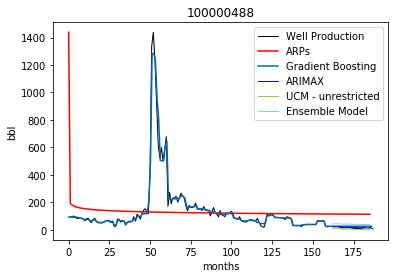

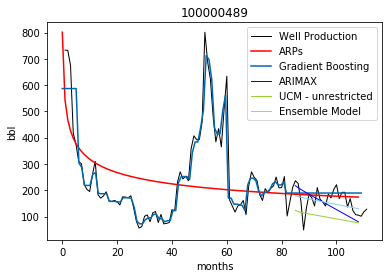

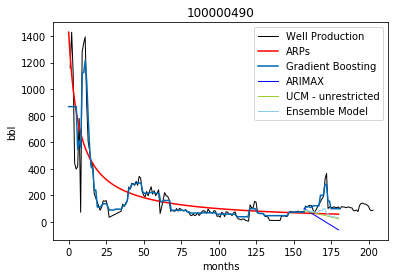

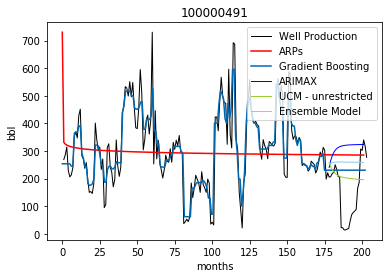

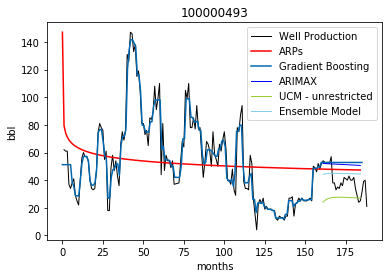

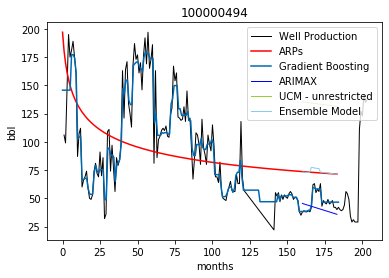

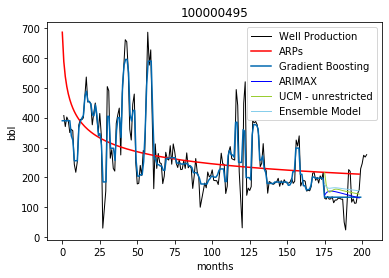

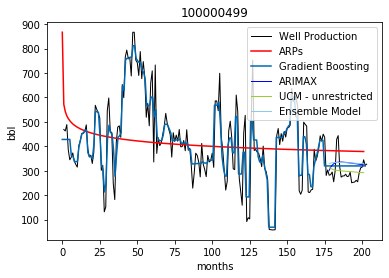

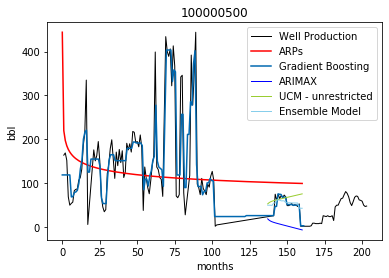

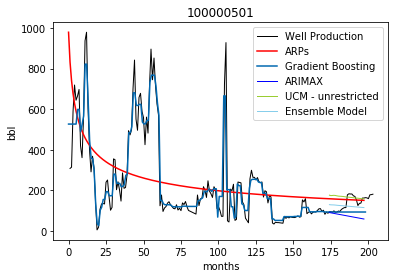

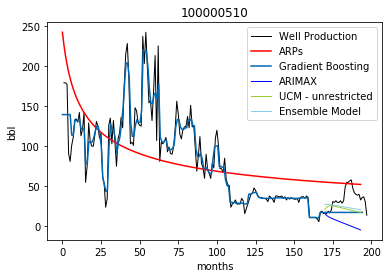

<Figure size 432x288 with 0 Axes>

In [70]:
columns = ['ARPs', 'GB', 'ARIMA', 'UCM', 'Ensemble', 'EUR', 'EUR Actual']
eur = pd.DataFrame([[0, 0, 0, 0, 0, 0, 0]], columns = columns)
eur['id'] = 'example'


for i in range( 100000007, 100111200):
    plot_data = df.loc[df['PWT__ID'] == i]

    #  droping production values that were zero - assuming that the well had to be shut down 
    #  and that will not affect future performance
    columns = ['OilorCondensateProduced']
    plot_data = plot_data.dropna()
    plot_data = plot_data.replace(0, pd.np.nan).dropna(axis=0, how='any', subset=columns)
    plot_data['Production'] = plot_data['OilorCondensateProduced']
    plot_data = plot_data.dropna()
    
    if len(plot_data['Production'].values) < 100:
        pass
    else:
        try:
            time_future = 24  
            columns = ['ARPs', 'GB', 'ARIMA', 'UCM', 'Ensemble', 'EUR', 'EUR Actual']
            results = Production_models(plot_data, time_future, str(i))
            results_df = pd.DataFrame([np.transpose(results)], columns = columns)
            results_df['id'] = str(i)
            eur = pd.concat([eur, results_df])            
        except:
            pass



In [71]:
eur.head()
len(eur)

95

In [102]:
eur_analysis = eur
eur_analysis['Total pct diff'] = abs(eur['EUR'] - eur['EUR Actual'])/((eur['EUR'] + eur['EUR Actual'])/2) * 100
eur_analysis.head(20)

new column  index           ARPs             GB          ARIMA  \
0           0      0       0.000000       0.000000       0.000000   
0           1      1   22655.824730   24249.130246    2267.030505   
0           2      2   75640.286204   79903.781228   69239.232142   
0           3      3   64013.635461   44145.351003   58680.306355   
0           4      4  221585.330172  232128.621001  107718.726287   
0           5      5  733420.609990  994083.455121  521824.169314   
0           6      6  846432.991396  994775.769391  555781.472536   
0           7      7  513743.709382  320898.462612  457083.738017   
0           8      8  767030.244209  731742.196340  486738.670997   
0           9      9  294987.971276  327103.907438  279259.844196   
0          10     10  885456.553890  564982.719164  523411.844822   
0          11     11  647119.500909  392193.028409  294802.786947   
0          12     12  878379.058845  912644.464677  323827.540960   
0          13     13  678340.816584  900057.377908  780240.307099   
0          14     14  558772.582857  381589.572583  436903.910714   
0          15     15  224433.789431  120240.843558     536.330996   
0          16     16  351363.839115  392433.298156  101075.608825   
0          17     17  580176.627644  429171.158888  428540.212397   
0          18     18  256552.202598  308245.912710  275165.700039   
0          19     19  290051.243892  331325.647957  249372.111379   

             UCM       Ensemble       EUR  EUR Actual  id  Total pct diff  
0       0.000000       0.000000       0.0         0.0   0             NaN  
0   14633.381733   15222.097921   15805.5     18000.0   1       12.983094  
0   76140.146069   73566.199302   74897.9     82464.0   2        9.616178  
0   47604.824343   52765.327986   53441.9     61704.0   3       14.350663  
0   14610.383650  139934.888205  143195.6    132144.0   4        8.027614  
0  372963.424127  634862.842656  651430.9    622320.0   5        4.570894  
0  591320.406125  726758.753872  743013.9    821736.0   6       10.061940  
0  447746.068177  221092.884415  392113.0    581736.0   7       38.942998  
0       0.000000    3502.707788  397802.8    862620.0   8       73.755759  
0   78896.502964    2698.188788  196589.3    277872.0   9       34.263153  
0  780869.365902  676909.647629  686326.0    868800.0  10       23.467423  
0  134472.241280  358976.201294  365512.8    344352.0  11        5.961924  
0  453379.073845  630466.715823  639739.4    983268.0  12       42.332352  
0  666328.841955   30103.988643  611014.3    686280.0  13       11.603489  
0  142654.364250  372030.324839  378390.2    357768.0  14        5.602654  
0   62977.161070   49897.937958   91617.2    105480.0  15       14.066968  
0  315401.739273  282637.086260  288582.3    439896.0  16       41.542404  
0  339528.305828   10692.531176  357621.8    381936.0  17        6.575335  
0  151156.287925     845.778284  198393.2    227136.0  18       13.509202  
0  231385.982855  268729.130795  274172.8    309600.0  19       12.137325

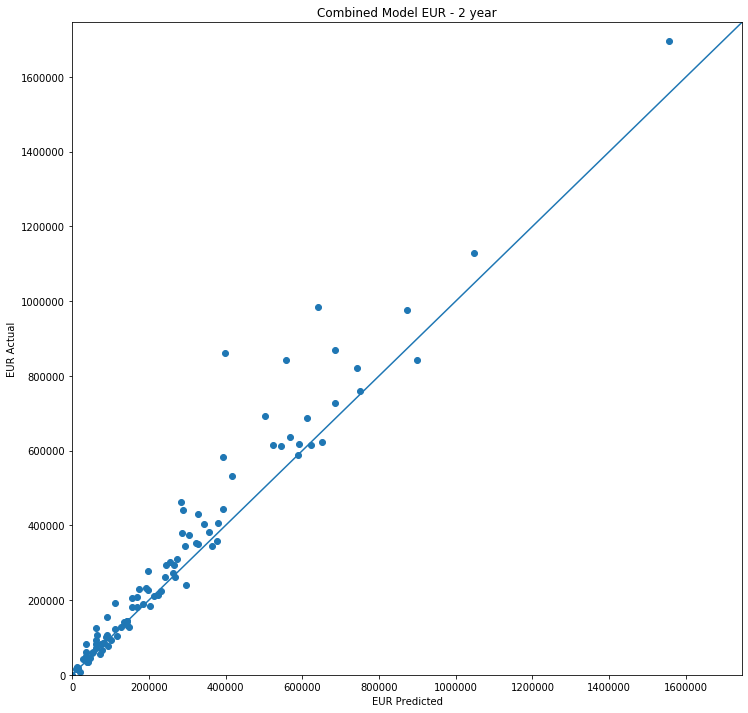

In [196]:
max_prod = max(eur_analysis['EUR Actual'].values)
fig = plt.figure(figsize = (12,12))


plt.scatter(eur_analysis['EUR'], eur_analysis['EUR Actual'], )
plt.xlabel('EUR Predicted')
plt.ylabel('EUR Actual')
lims = [0, max_prod+ 50000]
plt.xlim(lims)
plt.ylim(lims)
plt.title('Combined Model EUR - 2 year')
_ = plt.plot(lims, lims)
plt.show()


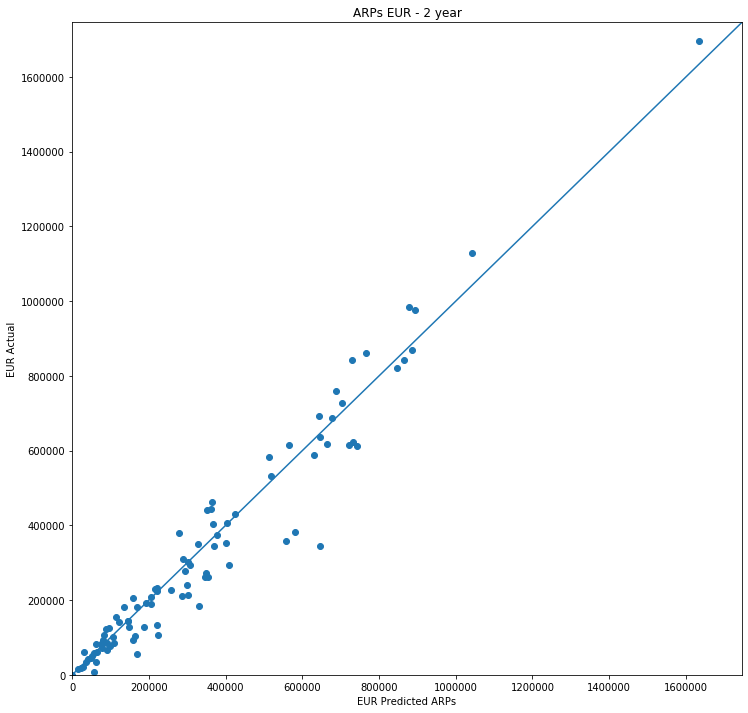

In [197]:
max_prod = max(eur_analysis['EUR Actual'].values)
fig = plt.figure(figsize = (12,12))


plt.scatter(eur_analysis['ARPs'], eur_analysis['EUR Actual'], )
plt.xlabel('EUR Predicted ARPs')
plt.ylabel('EUR Actual')
lims = [0, max_prod+ 50000]
plt.xlim(lims)
plt.ylim(lims)
plt.title('ARPs EUR - 2 year')
_ = plt.plot(lims, lims)
plt.show()


In [105]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [106]:
mae = mean_absolute_error(eur_analysis['EUR'].values, eur_analysis['EUR Actual'].values)
mse = mean_squared_error(eur_analysis['EUR'].values, eur_analysis['EUR Actual'].values)
rmse = mse ** 0.5
print('ensemble model:')
print("    mae - ", mae)
print("    rmse - ", rmse)

mae_arps = mean_absolute_error(eur_analysis['ARPs'].values, eur_analysis['EUR Actual'].values)
mse_arps = mean_squared_error(eur_analysis['ARPs'].values, eur_analysis['EUR Actual'].values)
rmse_arps = mse_arps ** 0.5
print('ARPs model:')
print("    mae - ", mae_arps)
print("    rmse - ", rmse_arps)

mae_GB = mean_absolute_error(eur_analysis['GB'].values, eur_analysis['EUR Actual'].values)
mse_GB = mean_squared_error(eur_analysis['GB'].values, eur_analysis['EUR Actual'].values)
rmse_GB = mse_GB ** 0.5
print('GB model:')
print("    mae - ", mae_GB)
print("    rmse - ", rmse_GB)

mae_ARIMA = mean_absolute_error(eur_analysis['ARIMA'].values, eur_analysis['EUR Actual'].values)
mse_ARIMA = mean_squared_error(eur_analysis['ARIMA'].values, eur_analysis['EUR Actual'].values)
rmse_ARIMA = mse_ARIMA ** 0.5
print('ARIMA model:')
print("    mae - ", mae_ARIMA)
print("    rmse - ", rmse_ARIMA)

mae_UCM = mean_absolute_error(eur_analysis['UCM'].values, eur_analysis['EUR Actual'].values)
mse_UCM = mean_squared_error(eur_analysis['UCM'].values, eur_analysis['EUR Actual'].values)
rmse_UCM = mse_ARIMA ** 0.5
print('UCM model:')
print("    mae - ", mae_UCM)
print("    rmse - ", rmse_UCM)

ensemble model:
    mae -  50586.53157894736
    rmse -  88869.09933751053
ARPs model:
    mae -  47038.284575812344
    rmse -  69703.13019502112
GB model:
    mae -  54714.34330880921
    rmse -  85207.61909416322
ARIMA model:
    mae -  89409.77408272219
    rmse -  152986.9188098339
UCM model:
    mae -  102115.48519671432
    rmse -  152986.9188098339


In [134]:

eur_analysis['EUR_act'] = eur_analysis['EUR Actual']
eur_analysis['id'] = range(0,len(eur_analysis))
eur_analysis_2 = eur_analysis[['id', 'ARPs', 'GB', 'ARIMA', 'UCM', 'Ensemble', 'EUR', 'EUR_act']]
eur_analysis_2.head()
eur_analysis_2.set_index('id')
#eur_analysis.head()

ARPs             GB          ARIMA           UCM       Ensemble  \
id                                                                             
0        0.000000       0.000000       0.000000      0.000000       0.000000   
1    22655.824730   24249.130246    2267.030505  14633.381733   15222.097921   
2    75640.286204   79903.781228   69239.232142  76140.146069   73566.199302   
3    64013.635461   44145.351003   58680.306355  47604.824343   52765.327986   
4   221585.330172  232128.621001  107718.726287  14610.383650  139934.888205   
..            ...            ...            ...           ...            ...   
90   31594.163228   77865.350733   10758.020179  28590.641483   36090.831563   
91   36699.868162   26509.550800   20658.958656  67539.855317   37308.060872   
92  108197.176410   73705.791014   73549.200252  78980.237424   82072.563962   
93   78182.539327   51447.461629   38113.833101  84871.469264   62082.003713   
94   27233.562818    9664.524874    2138.614157  11395.868329   12508.543529   

         EUR   EUR_act  
id                      
0        0.0       0.0  
1    15805.5   18000.0  
2    74897.9   82464.0  
3    53441.9   61704.0  
4   143195.6  132144.0  
..       ...       ...  
90   36979.8   60348.0  
91   37743.3   33588.0  
92   83301.0   84372.0  
93   62939.5   83244.0  
94   12588.2   21168.0  

[95 rows x 7 columns]

## What if the best model is selected?

In [190]:
best = []

arps = abs(eur_analysis_2['EUR_act'] - eur_analysis_2['ARPs']).values.reshape(-1,1)
gb = abs(eur_analysis_2['EUR_act'] - eur_analysis_2['GB']).values.reshape(-1,1)
ARIMA = abs(eur_analysis_2['EUR_act'] - eur_analysis_2['ARIMA']).values.reshape(-1,1)
UCM = abs(eur_analysis_2['EUR_act'] - eur_analysis_2['UCM']).values.reshape(-1,1)
EUR = abs(eur_analysis_2['EUR_act'] - eur_analysis_2['EUR']).values.reshape(-1,1)

arps_val = eur_analysis_2['ARPs'].values.reshape(-1,1)
gb_val = eur_analysis_2['GB'].values.reshape(-1,1)
ARIMA_val = eur_analysis_2['ARIMA'].values.reshape(-1,1)
UCM_val = eur_analysis_2['UCM'].values.reshape(-1,1)
EUR_val = eur_analysis_2['EUR'].values.reshape(-1,1)


for  i in range(0, len(eur_analysis_2)):
    if arps[i] < gb[i] and arps[i] < ARIMA[i] and arps[i] < UCM[i] and arps[i] < EUR[i]:
        best.append(arps_val[i])
    elif gb[i] < ARIMA[i] and gb[i] < UCM[i] and gb[i] < EUR[i]:
        best.append(gb_val[i])
    elif ARIMA[i] < UCM[i] and ARIMA[i] < EUR[i]:
        best.append(ARIMA_val[i])
    elif UCM[i] < EUR[i]:
        best.append(UCM_val[i])
    else: 
        best.append(EUR_val[i])

best = np.array(best)      



In [191]:
eur_analysis_2['best'] = best

eur_analysis_2.head()

id           ARPs             GB          ARIMA           UCM  \
0   0       0.000000       0.000000       0.000000      0.000000   
0   1   22655.824730   24249.130246    2267.030505  14633.381733   
0   2   75640.286204   79903.781228   69239.232142  76140.146069   
0   3   64013.635461   44145.351003   58680.306355  47604.824343   
0   4  221585.330172  232128.621001  107718.726287  14610.383650   

        Ensemble       EUR   EUR_act      ARP diff       GB diff  \
0       0.000000       0.0       0.0      0.000000      0.000000   
0   15222.097921   15805.5   18000.0   4655.824730   6249.130246   
0   73566.199302   74897.9   82464.0   6823.713796   2560.218772   
0   52765.327986   53441.9   61704.0   2309.635461  17558.648997   
0  139934.888205  143195.6  132144.0  89441.330172  99984.621001   

            best  
0       0.000000  
0   15805.500000  
0   79903.781228  
0   64013.635461  
0  143195.600000

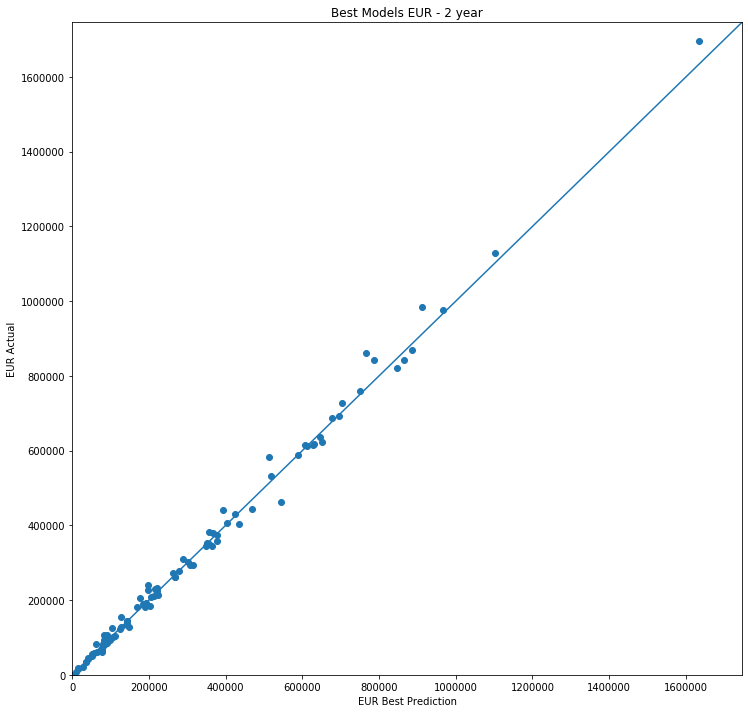

In [198]:
max_prod = max(eur_analysis['EUR Actual'].values)
fig = plt.figure(figsize = (12,12))


plt.scatter(eur_analysis_2['best'], eur_analysis_2['EUR_act'], )
plt.xlabel('EUR Best Prediction')
plt.ylabel('EUR Actual')
lims = [0, max_prod+ 50000]
plt.xlim(lims)
plt.ylim(lims)
plt.title('Best Models EUR - 2 year')
_ = plt.plot(lims, lims)
plt.show()


In [199]:
mae = mean_absolute_error(eur_analysis['EUR'].values, eur_analysis['EUR Actual'].values)
mse = mean_squared_error(eur_analysis['EUR'].values, eur_analysis['EUR Actual'].values)
rmse = mse ** 0.5
print('ensemble model:')
print("    mae - ", mae)
print("    rmse - ", rmse)

mae_arps = mean_absolute_error(eur_analysis['ARPs'].values, eur_analysis['EUR Actual'].values)
mse_arps = mean_squared_error(eur_analysis['ARPs'].values, eur_analysis['EUR Actual'].values)
rmse_arps = mse_arps ** 0.5
print('ARPs model:')
print("    mae - ", mae_arps)
print("    rmse - ", rmse_arps)

mae_GB = mean_absolute_error(eur_analysis['GB'].values, eur_analysis['EUR Actual'].values)
mse_GB = mean_squared_error(eur_analysis['GB'].values, eur_analysis['EUR Actual'].values)
rmse_GB = mse_GB ** 0.5
print('GB model:')
print("    mae - ", mae_GB)
print("    rmse - ", rmse_GB)

mae_ARIMA = mean_absolute_error(eur_analysis['ARIMA'].values, eur_analysis['EUR Actual'].values)
mse_ARIMA = mean_squared_error(eur_analysis['ARIMA'].values, eur_analysis['EUR Actual'].values)
rmse_ARIMA = mse_ARIMA ** 0.5
print('ARIMA model:')
print("    mae - ", mae_ARIMA)
print("    rmse - ", rmse_ARIMA)

mae_UCM = mean_absolute_error(eur_analysis['UCM'].values, eur_analysis['EUR Actual'].values)
mse_UCM = mean_squared_error(eur_analysis['UCM'].values, eur_analysis['EUR Actual'].values)
rmse_UCM = mse_UCM ** 0.5
print('UCM model:')
print("    mae - ", mae_UCM)
print("    rmse - ", rmse_UCM)

mae_best = mean_absolute_error(eur_analysis_2['best'].values, eur_analysis['EUR_act'].values)
mse_best = mean_squared_error(eur_analysis_2['best'].values, eur_analysis['EUR_act'].values)
rmse_best = mse_best ** 0.5
print('Best models:')
print("    mae - ", mae_best)
print("    rmse - ", rmse_best)

ensemble model:
    mae -  50586.53157894736
    rmse -  88869.09933751053
ARPs model:
    mae -  47038.284575812344
    rmse -  69703.13019502112
GB model:
    mae -  54714.34330880921
    rmse -  85207.61909416322
ARIMA model:
    mae -  89409.77408272219
    rmse -  152986.9188098339
UCM model:
    mae -  102115.48519671432
    rmse -  173251.89074120935
Best models:
    mae -  14537.172456263284
    rmse -  23420.31662506413
